# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt


In [2]:
#загружаем данные
df1 = pd.read_csv('Ya_data/oil_well/geo_data_0.csv')
df2 = pd.read_csv('Ya_data/oil_well/geo_data_1.csv')
df3 = pd.read_csv('Ya_data/oil_well/geo_data_2.csv')

Смотрим содержимое данных

In [3]:
df1.sample(5 ,random_state = 111)

,id,f0,f1,f2,product
92509,7EPcC,-0.456685,1.064066,7.701457,109.489200
99094,H7fGp,0.852552,0.142478,0.849195,40.021622
78961,VJNOM,-0.825040,0.512715,2.711929,66.960887
13302,m6dyP,0.689321,0.860754,2.755276,143.815323
67956,qj1Pp,0.796073,0.848364,3.795867,38.783193


In [4]:
df2.sample(5 ,random_state = 111)

,id,f0,f1,f2,product
92509,AWeV4,-8.137635,-8.876179,2.995424,84.038886
99094,65Wmb,-4.980060,-3.412528,1.001200,30.132364
78961,T4t2G,2.439433,-0.443882,3.003695,80.859783
13302,BXcLd,7.339515,-5.100007,0.000040,0.000000
67956,wPnl3,-10.652136,-4.951828,0.013041,3.179103


In [5]:
df3.sample(5 ,random_state = 111)

,id,f0,f1,f2,product
92509,88V4S,2.243522,-1.032774,3.185736,96.667190
99094,t8Vzg,3.232932,2.196337,5.526300,169.430616
78961,VSWcf,-2.589039,3.131111,-2.676642,46.612179
13302,1iN6u,0.338558,-1.137644,4.676254,82.363525
67956,2VAw3,-0.696509,-3.522404,6.014087,154.593880


Посмотрим информацию о файлах

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Каждый файл модержит по 100 тыс. объектов в 5ти столбцах:\
id — уникальный идентификатор скважины;\
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);\
product — объём запасов в скважине (тыс. баррелей).\
Пропусков нет.


Проверим уникальные id на уникальность

In [9]:
ids = df1['id']
df1[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [10]:
ids = df2['id']
df2[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [11]:
ids = df3['id']
df3[ids.isin(ids[ids.duplicated()])].sort_values('id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Во всех 3х датасетах имеется небольшое количество дубликатов id, но с разными признаками. Возможно это старые и обновленные данные которые забыли удалить. Нас интересует только связь трех признаков с объемом запасов, поэтому на обучение модели данная аномалия не повлияет, оставим данные без изменений. Признак id удалим за ненадобностью.

In [12]:
df1 = df1.drop(['id'], axis = 1)
df2 = df2.drop(['id'], axis = 1)
df3 = df3.drop(['id'], axis = 1)

Посмотрим на распределение целевого признака

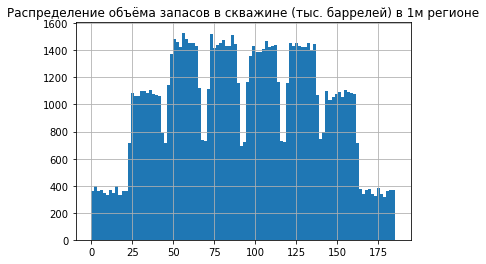

In [13]:
df1['product'].hist(bins=100)
plt.title('Распределение объёма запасов в скважине (тыс. баррелей) в 1м регионе')
plt.show()

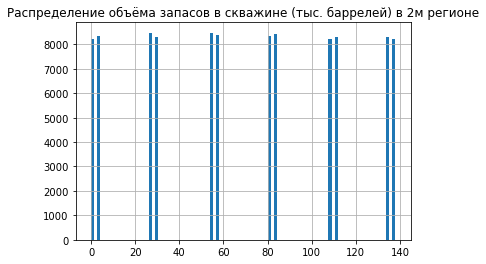

In [14]:
df2['product'].hist(bins=100)
plt.title('Распределение объёма запасов в скважине (тыс. баррелей) в 2м регионе')
plt.show()

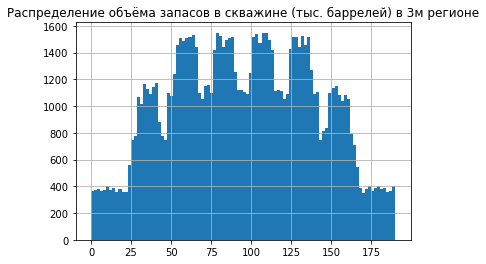

In [15]:
df3['product'].hist(bins=100)
plt.title('Распределение объёма запасов в скважине (тыс. баррелей) в 3м регионе')
plt.show()

Распределение имеют интересную форму. 2й регион сильно отличается. По описанию задачи данные искуственные.

### Вывод

Посмотрели на исходдные данные. Удилили лишнее. Кодирование или масштабирование признаков для предоставленных данных не требуется. 

## Обучение и проверка модели

По условиям задачи для обучения модели подходит только линейная регрессия, поэтому используем эту модель.

In [16]:
df1.name = 'df1'
df2.name = 'df2'
df3.name = 'df3'
datasets = [df1, df2, df3]

for data in datasets:
    features = data.drop('product', axis = 1) # признаки 
    target = data['product'] # целевой признак
    features_train, features_valid, target_train, target_valid = train_test_split(
                                                                        features, target, test_size=0.25, random_state=12345)
    print('Обучающие объекты {} : признаки {}, цель {}'.format(data.name ,features_train.shape, target_train.shape))
    print('Валидационные объекты {}: признаки {}, цель {}'.format(data.name,features_valid.shape, target_valid.shape))
    globals()['target_valid_%s' % data.name] = target_valid.reset_index(drop=True) # для дальнейшего сопоставления сбросим индексы
    model = LinearRegression()
    model.fit(features_train, target_train) # обучение на тренировочной выборке
    #globals()['model_%s' % data.name] = model
    predictions_valid = model.predict(features_valid) #  предсказания модели на валидационной выборке
    globals()['predictions_valid_%s' % data.name] = pd.Series(predictions_valid) # для дальнейшего сопоставления преобразуем в серию
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5 # RMSE на валидационной выборке
    globals()['RMSE_%s' % data.name] = result
    print("")
    print("Cредний запас предсказанного сырья на валидационной выборке {}:{: .2f} тыс. баррелей".format(data.name, predictions_valid.mean()))
    print("RMSE линейной регрессии на валидационной выборке {}:{: .2f}".format(data.name, result))
    print("")
    print("Предсказания и правильные ответы на валидационной выборке сохранены в переменных predictions_valid_{} и target_valid_{}" .format(data.name, data.name))
    print("_____________________________________________________________________________________________________________________________")
         

Обучающие объекты df1 : признаки (75000, 3), цель (75000,)
Валидационные объекты df1: признаки (25000, 3), цель (25000,)

Cредний запас предсказанного сырья на валидационной выборке df1: 92.59 тыс. баррелей
RMSE линейной регрессии на валидационной выборке df1: 37.58

Предсказания и правильные ответы на валидационной выборке сохранены в переменных predictions_valid_df1 и target_valid_df1
_____________________________________________________________________________________________________________________________
Обучающие объекты df2 : признаки (75000, 3), цель (75000,)
Валидационные объекты df2: признаки (25000, 3), цель (25000,)

Cредний запас предсказанного сырья на валидационной выборке df2: 68.73 тыс. баррелей
RMSE линейной регрессии на валидационной выборке df2: 0.89

Предсказания и правильные ответы на валидационной выборке сохранены в переменных predictions_valid_df2 и target_valid_df2
_______________________________________________________________________________________________

### Вывод

Обучили модели для 3х разных регионов и посчитали предсказания. Метрики точности предсказаний RMSE для регионов df1 и df3 примерно одинаковы 37 и 40. Для региона df2 метрика RMSE = 1, что является почти идеальным результатом. Это объясняется распределением целевых признаков показанным выше. Средний запас  предсказанного сырья больше всего в регионе df3 (94.97 тыс. баррелей). 

## Подготовка к расчёту прибыли

Ключевые значения для расчётов сохраним в отдельных переменных

In [17]:
BUDGET_PER_REGION = 10e9 # Бюджет на разработку скважин в регионе
PROFIT_PER_UNIT = 450e3 #Доход с каждой единицы продукта
EXP_POINT_PER_REGION = 500 #Количество исследуемых точек
DEV_POINT_PER_REGION = 200 #Количество разрабатываемых точек

Посчитаем достаточный объём сырья для безубыточной разработки новой скважины. Разделим бюджет разработки на регион на доход с единицы продукта и на общще колличество разрабатываемых скважин.

In [18]:
Vol_CVP = BUDGET_PER_REGION / PROFIT_PER_UNIT / DEV_POINT_PER_REGION
print('Достаточный объём сырья для безубыточной разработки новой скважины:', Vol_CVP)

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111


Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [19]:
def profit_top_target_by_predict(predict, target, top_N):
    #в бустрапе берутся элементы с повторениями, т.е. с одинаковыми индексами в массиве появляются лишние элементы. обрежем их.
    top_idx = predict.sort_values(ascending=False)[:top_N].index 
    return target[top_idx][:top_N].sum()*PROFIT_PER_UNIT - BUDGET_PER_REGION  

### Вывод

Расчеты показывают,что каждая из 200 скважин должна иметь объем запасов не менее 111 тыс. баррелей. Это больше чем средний обьем сважин по любому региону.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Посчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков. 

In [20]:
state = np.random.RandomState(12345)
def bootstrap(predict, target, subsample):    
    values = []
    for i in range(1000):
    
        target_subsample = target.sample(n=EXP_POINT_PER_REGION, replace=True, random_state=state)
        predict_subsample = predict[target_subsample.index]
        values.append(profit_top_target_by_predict(predict_subsample, target_subsample, DEV_POINT_PER_REGION))
                             
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    risk_of_losses =  values.loc[values < 0].count() / 1000 *100
    mean = values.mean()
    print("Средняя прибыль, млрд:", round(mean / 1e6))
    print("2.5%-квантиль, млрд:", round(lower / 1e6))
    print("97.5%-квантиль, млрд:", round(upper / 1e6))
    print("Риск убытков, %", risk_of_losses)
    values.hist(bins=50, figsize = (11,5))
    plt.title('Распределение прибыли')

    plt.axvline(lower, color = 'red')
    plt.axvline(upper, color = 'red')
    
      
    return round(mean / 1e6), risk_of_losses

### Регион 1

Средняя прибыль, млрд: 426
2.5%-квантиль, млрд: -102
97.5%-квантиль, млрд: 948
Риск убытков, % 6.0


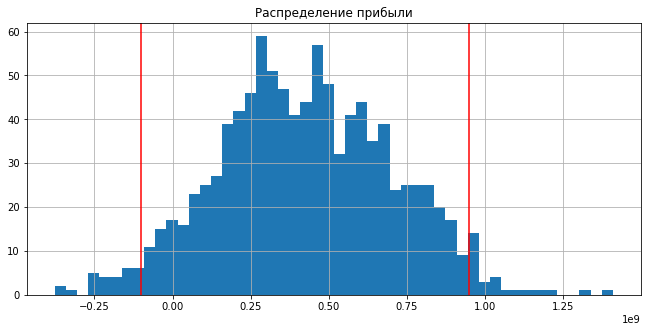

In [21]:
result_1 = bootstrap(predictions_valid_df1, target_valid_df1, EXP_POINT_PER_REGION)

### Регион 2

Средняя прибыль, млрд: 518
2.5%-квантиль, млрд: 128
97.5%-квантиль, млрд: 954
Риск убытков, % 0.3


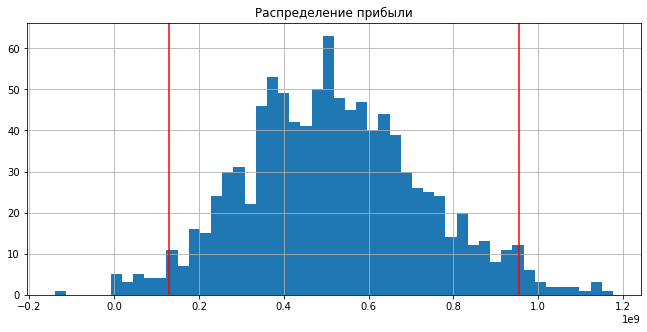

In [22]:
result_2 = bootstrap(predictions_valid_df2, target_valid_df2, EXP_POINT_PER_REGION)

### Регион 3

Средняя прибыль, млрд: 420
2.5%-квантиль, млрд: -116
97.5%-квантиль, млрд: 990
Риск убытков, % 6.2


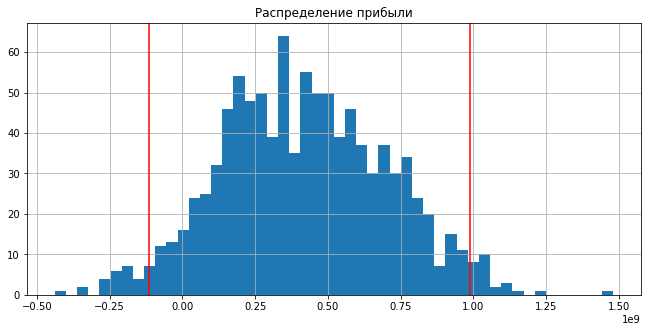

In [23]:
result_3 = bootstrap(predictions_valid_df3, target_valid_df3, EXP_POINT_PER_REGION)

### Вывод

Итоговая тоблица стредней прибыли, рисков убытков и метрики модели по регионам.

In [24]:
pd.DataFrame({'Регион':['Средняя прибыль, млрд', 'Риск убытков, %', 'RMSE модели'], 
              '1': [result_1[0], result_1[1], round(RMSE_df1)], 
              '2' :[result_2[0], result_2[1], round(RMSE_df2)],
              '3': [result_3[0], result_3[1], round(RMSE_df3)]})

,Регион,1,2,3
0,"Средняя прибыль, млрд",426.0,518.0,420.0
1,"Риск убытков, %",6.0,0.3,6.2
2,RMSE модели,38.0,1.0,40.0


Наибольшую среднюю прибыль показывает 2й регион. Безубыточный 2,5% порог преодолел только 2й регион. Лучший  регион для разработки скважин номер 2. Несмотрия на наименьший средний запас предсказанного сырья он показал самую большую среднюю прибыль при разработке 200 скважин выбранных из случайных 500 скважин. Кроме того у него наибольшая точность предсказания модели и минимальный риск убытков. Самый большой риск убытков в 3м регионе. 

## Общий вывод

Определен регион, где добыча принесёт наибольшую прибыль. С помощью техники Bootstrap проанализирована возможная прибыль и риски. В итоге наибольшую среднюю вероятную прибыль показал регион с наименьшим средним запасом по скажинам.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован